In [1]:
import os
import shutil, sys 

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Rescaling
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Read csv with all bird names
bird_species = pd.read_csv('../data/class_dict.csv')
# Randomly select 10 birds
bird_list = sorted (random.sample (list (bird_species['class']), 10))
bird_list

['BLACKBURNIAM WARBLER',
 'BORNEAN PHEASANT',
 'BROWN CREPPER',
 'D-ARNAUDS BARBET',
 'GANG GANG COCKATOO',
 'INDIAN ROLLER',
 'JAVA SPARROW',
 'PARADISE TANAGER',
 'STRIPPED SWALLOW',
 'TRUMPTER SWAN']

In [3]:
# Move images of randomly selected birds to destination folder

# All-birds folder locations
original_dir_train = '../data/train'
original_dir_test = '../data/test'
original_dir_valid = '../data/valid'
# Destination folders for shutil
destination_dir_train = '../data/10_birds/train'
destination_dir_test = '../data/10_birds/test'
destination_dir_valid = '../data/10_birds/valid'

def move_subfolders(original_dir, destination):
    ''' Moves folder matching randomly selected birds to 10_birds sub-folder '''
    list_dir = os.listdir(original_dir)
    for sub_dir in list_dir:
        if sub_dir in bird_list:
            # Move subfolders to destination
            dir_to_move = os.path.join(original_dir, sub_dir)
            shutil.move(dir_to_move, destination)

# NOTE: Need to make empty train/test/valid folders ahead of time or it will dump contents of first 
# bird_list folder without first creating class folder
move_subfolders(original_dir_train, destination_dir_train)
move_subfolders(original_dir_test, destination_dir_test)
move_subfolders(original_dir_valid, destination_dir_valid)

In [4]:
''' Moves files back to 315 birds data folder (Use if you do not like the current selection)'''
# move_subfolders(destination_dir_train, original_dir_train)
# move_subfolders(destination_dir_test, original_dir_test)
# move_subfolders(destination_dir_valid, original_dir_valid)

' Moves files back to 315 birds data folder (Use if you do not like the current selection)'

In [22]:
# Define train/test directories
train_dir = '../data/10_birds/train'
test_dir = '../data/10_birds/test'
valid_dir = '../data/10_birds/valid'

# Find class labels
classes = os.listdir(train_dir)
print(classes)

['BLACKBURNIAM WARBLER', 'BORNEAN PHEASANT', 'BROWN CREPPER', 'D-ARNAUDS BARBET', 'GANG GANG COCKATOO', 'INDIAN ROLLER', 'JAVA SPARROW', 'PARADISE TANAGER', 'STRIPPED SWALLOW', 'TRUMPTER SWAN']


In [23]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

# Create training dataset and reduce images to 64x64, shuffle 
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir, label_mode='categorical', 
                                                         image_size=(128, 128), batch_size=32)
# Create testing dataset and reduce images to 64x64
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir, label_mode='categorical',
                                                        image_size=(128, 128), batch_size=32, shuffle=False)
# Create validation dataset and reduce images to 64x64
valid_dataset = tf.keras.utils.image_dataset_from_directory(valid_dir, label_mode='categorical',
                                                         image_size=(128, 128), batch_size=32, shuffle=False)

Found 1550 files belonging to 10 classes.
Found 50 files belonging to 10 classes.
Found 50 files belonging to 10 classes.


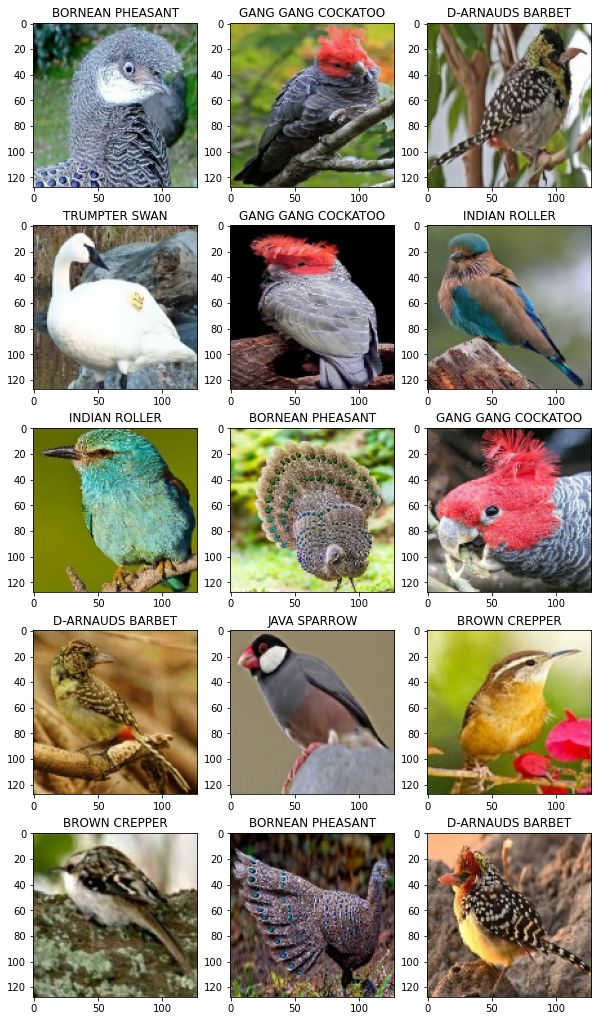

In [27]:
# View random sampling of birds with class labels
plt.figure(figsize=(10, 18))

for images, labels in train_dataset.take(2):
    for i in range(15):
        ax = plt.subplot(5, 3, i+1)
        plt.imshow(images[i].numpy().astype('int'))
        plt.title(classes[tf.argmax(labels[i])], fontsize=12) 

In [28]:
def normalize_data(dataset):
    ''' Normalize images to by rescaling to 1./255 (max value) '''
    normalize_layer = Rescaling(1./255)
    normalized = dataset.map(lambda x, y: (normalize_layer(x), y))
    
    return normalized

# Normalize train/test/validation datasets
training_data_normal = normalize_data(train_dataset)
testing_data_normal = normalize_data(test_dataset)
validation_data_normal = normalize_data(valid_dataset)

In [29]:
# Initialize model
model = Sequential() #simple sequantial model

model.add(Conv2D(64, (3,3), input_shape = (128,128,3)))
#64 is the number of nodes
#(3,3) is the window we want to consider
#the shape starts at 1 because the first shape isn't actually data
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
#we flatten because conv is 2d and Dense requires 1d
model.add(Dense(64))

model.add(Dense(10))
model.add(Activation('softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
# Fit model to training data, validate on testing data
cnn_model = model.fit(training_data_normal, batch_size=150, epochs=10, validation_data=testing_data_normal)

Epoch 1/10
49/49 [==============================] - 14s 278ms/step - loss: 2.2571 - accuracy: 0.3703 - val_loss: 0.8868 - val_accuracy: 0.7400
Epoch 2/10
49/49 [==============================] - 14s 282ms/step - loss: 0.8226 - accuracy: 0.7529 - val_loss: 0.3791 - val_accuracy: 0.9200
Epoch 3/10
49/49 [==============================] - 14s 278ms/step - loss: 0.3789 - accuracy: 0.8942 - val_loss: 0.3812 - val_accuracy: 0.8600
Epoch 4/10
49/49 [==============================] - 14s 279ms/step - loss: 0.1805 - accuracy: 0.9510 - val_loss: 0.3279 - val_accuracy: 0.9200
Epoch 5/10
49/49 [==============================] - 14s 278ms/step - loss: 0.0710 - accuracy: 0.9852 - val_loss: 0.2279 - val_accuracy: 0.9400
Epoch 6/10
49/49 [==============================] - 14s 280ms/step - loss: 0.0240 - accuracy: 0.9942 - val_loss: 0.2019 - val_accuracy: 0.8800
Epoch 7/10
49/49 [==============================] - 14s 279ms/step - loss: 0.0230 - accuracy: 0.9942 - val_loss: 0.3265 - val_accuracy: 0.9000

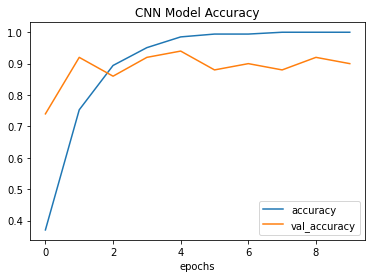

In [39]:
# Plot model accuracy
plt.figure(figsize=(6,4))

plt.plot(cnn_model.history['accuracy'], label='accuracy')
plt.plot(cnn_model.history['val_accuracy'], label='val_accuracy')

plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel('epochs')
plt.title('CNN Model Accuracy')

plt.show()

Text(0.5, 1.0, 'CNN Model Loss')

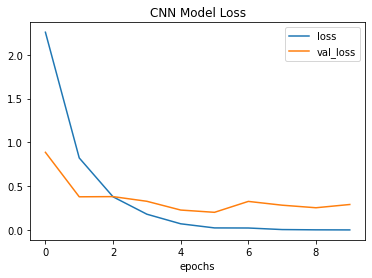

In [40]:
# Plot model loss
plt.figure(figsize=(6,4))

plt.plot(cnn_model.history['loss'], label='loss')
plt.plot(cnn_model.history['val_loss'], label='val_loss')

plt.legend(['loss', 'val_loss'])
plt.xlabel('epochs')

plt.title('CNN Model Loss')

In [41]:
# Evaluate on holdout validation data
model.evaluate(valid_dataset, verbose=1)

2/2 [==============================] - 0s 40ms/step - loss: 92.1388 - accuracy: 0.9000


[92.13883972167969, 0.8999999761581421]

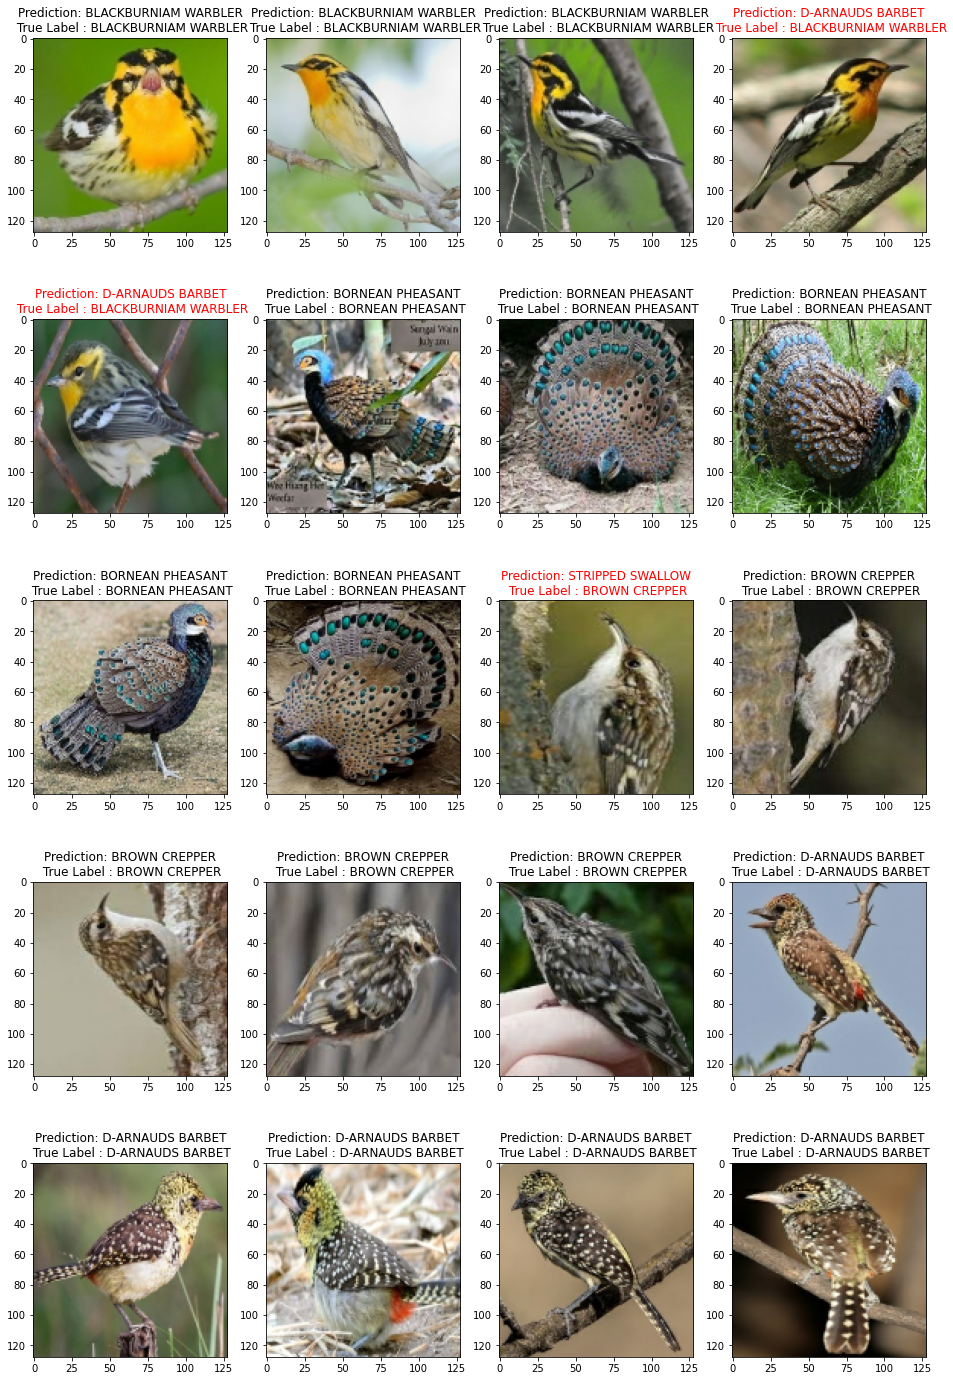

In [44]:
# Plot sampling of bird with predicted and actual labels
plt.figure(figsize=(16, 25))

for image, label in testing_data_normal.take(1):
    model_prediction = model.predict(image)
    for i in range(20):
        plt.subplot(5, 4, i+1)
        plt.imshow(image[i])
        plt.title(f'Prediction: {classes[tf.argmax(model_prediction[i])]}\n True Label : {classes[tf.argmax(label[i])]}', 
                  fontsize=12, color='black' if classes[tf.argmax(model_prediction[i])] == classes[tf.argmax(label[i])] else 'red')
    plt.show()

In [43]:
# Make class predictions
preds = model.predict_generator(test_dataset)
class_preds = tf.argmax(preds,1)

predicted_classes = np.array(class_preds)
predicted_classes

C:\Users\Soronson\AppData\Local\Temp/ipykernel_5220/2230506853.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_dataset)


array([0, 0, 0, 3, 0, 3, 1, 1, 1, 1, 8, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 3,
       8, 9, 9, 9, 6, 9], dtype=int64)

In [45]:
# True labels of un-shuffled testing data
true = np.concatenate([y for x, y in test_dataset], axis=0)
true = tf.argmax(true,1)
true

<tf.Tensor: shape=(50,), dtype=int64, numpy=
array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8,
       8, 9, 9, 9, 9, 9], dtype=int64)>

In [46]:
# Run classification report
print(classification_report(predicted_classes, true))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       0.80      1.00      0.89         4
           2       0.80      1.00      0.89         4
           3       1.00      0.62      0.77         8
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      0.83      0.91         6
           7       1.00      1.00      1.00         5
           8       0.80      0.80      0.80         5
           9       0.80      1.00      0.89         4

    accuracy                           0.90        50
   macro avg       0.90      0.93      0.90        50
weighted avg       0.92      0.90      0.90        50



<AxesSubplot:>

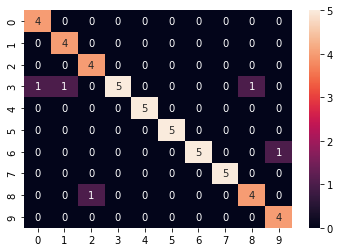

In [47]:
# View confusion matrix
cm = confusion_matrix(predicted_classes, true)
sns.heatmap(cm, annot=True)

In [20]:
''' Moves files back to 315 birds data folder (Use before closing notebook)'''
# move_subfolders(destination_dir_train, original_dir_train)
# move_subfolders(destination_dir_test, original_dir_test)
# move_subfolders(destination_dir_valid, original_dir_valid)

' Moves files back to 315 birds data folder (Use before closing notebook)'